## Traininig of the High Level Feature classifier with TensorFlow/Keras and Petastorm

**Tensorflow/Keras and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Data is read using the Petastorm library.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Create the Keras model

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

tf.version.VERSION

In [ ]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

In [3]:
def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [ ]:
# define the Keras model
keras_model = create_model(50, 20, 10)

## Load data and train the Keras model

In [5]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "file:///eos/project/s/sparkdltrigger/public/"

file_train_dataset = PATH + "trainUndersampled_HLF_features.parquet"
file_test_dataset = PATH + "testUndersampled_HLF_features.parquet"

# PATH needs to be prefixed by the fileystem type as in:
# "file://<full_path>_on_filesystem/Parquet_folder/"
# "hdfs://<full_path_on_hdfs>/Parquet_folder/"


In [ ]:
# Install petastorm if not done yet
!pip install petastorm

In [6]:
# We use the petastorm libary to load and feed the training and test data in Parquet format
# It makes use TensorFLow tf.data.dataset

import petastorm
from petastorm import make_batch_reader
from petastorm.tf_utils import make_petastorm_dataset

petastorm.__version__

'0.12.1'

In [8]:
#
# Train with TensorFlow using Petastorm to read Parquet files
# This performs a rebatching operation on the training dataset  to set explicitly the bach size,
# as otherwise Petastorm produces batches with Parquet rowgroup size, which is often too large. 
# 

batch_size = 128
n_epochs = 5

with make_batch_reader(file_test_dataset, num_epochs = 1, shuffle_row_groups = False) as test_data:
    with make_batch_reader(file_train_dataset, num_epochs = 1, shuffle_row_groups = True) as train_data:
        print("Number of training rows:", train_data.dataset.read().num_rows)
        #
        # Transform Parquet files into TensorFLow datasets (tf.data API)
        #
        test_dataset = make_petastorm_dataset(test_data).cache()
        train_dataset = ( make_petastorm_dataset(train_data)
                            .unbatch()  # change this for rebatch with tensorflow 2.11
                            .batch(batch_size)
                            .cache()
                        )
        #
        # Train the Keras model
        #
        history = keras_model.fit(train_dataset,
                                  validation_data = test_dataset,
                                  epochs = n_epochs, verbose=1)                               

Number of training rows: 3426083
Epoch 1/5


2023-05-16 13:35:17.483535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 13:35:23.358014: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4d3c00b220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 13:35:23.358069: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-16 13:35:23.415371: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 13:35:23.912050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 13:35:24.466220: I ./tensor

  26762/Unknown - 317s 12ms/step - loss: 0.2809 - accuracy: 0.8972

2023-05-16 13:40:35.201315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26767/26767 [==============================] - 346s 13ms/step - loss: 0.2809 - accuracy: 0.8972 - val_loss: 0.2547 - val_accuracy: 0.9054
Epoch 2/5
26767/26767 [==============================] - 201s 8ms/step - loss: 0.2443 - accuracy: 0.9098 - val_loss: 0.2391 - val_accuracy: 0.9118
Epoch 3/5
26767/26767 [==============================] - 206s 8ms/step - loss: 0.2374 - accuracy: 0.9122 - val_loss: 0.2338 - val_accuracy: 0.9139
Epoch 4/5
26767/26767 [==============================] - 206s 8ms/step - loss: 0.2333 - accuracy: 0.9136 - val_loss: 0.2304 - val_accuracy: 0.9151
Epoch 5/5
26767/26767 [==============================] - 202s 8ms/step - loss: 0.2306 - accuracy: 0.9148 - val_loss: 0.2283 - val_accuracy: 0.9158


## Performance metrics

<IPython.core.display.Javascript object>


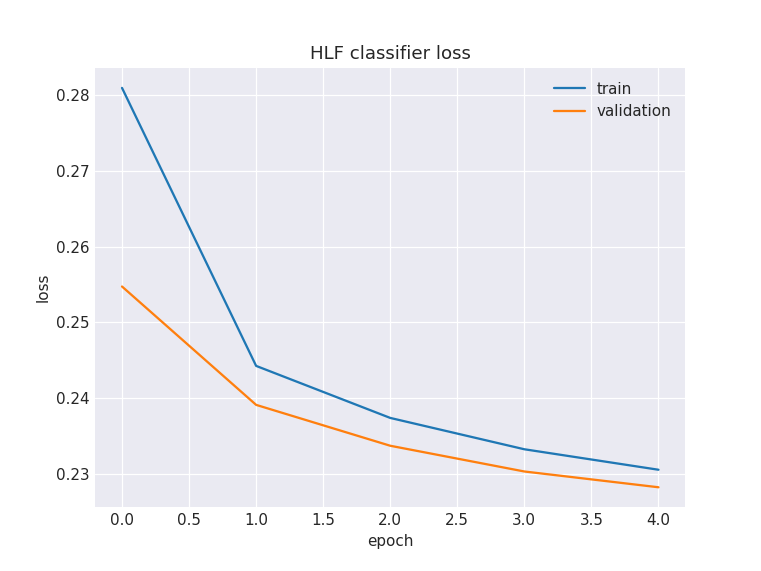

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


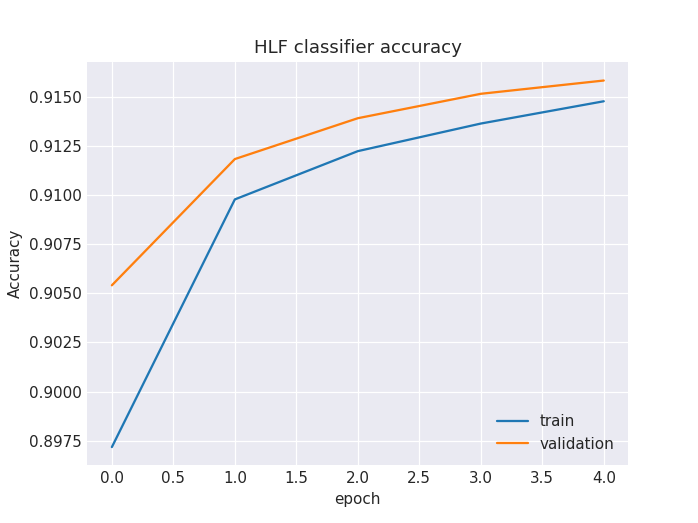

In [12]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [14]:
import numpy as np

# Need to use workers_count=1 to avoid getting data potentially in different order at each execution
with make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False) as test_data:
    y_pred = history.model.predict(test_data)


      5/Unknown - 0s 25ms/step

2023-05-16 14:31:54.938283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


114/114 [==============================] - 3s 24ms/step


In [15]:
# Need to use workers_count=1 to avoid getting data potentially in different order at each execution
with make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False) as test_data:
    y_true = np.concatenate([labels for features,labels in test_data])

In [16]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9158


<IPython.core.display.Javascript object>


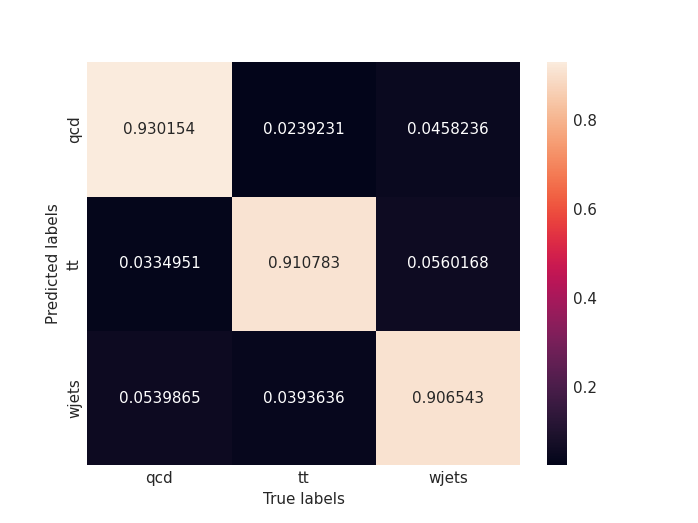

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [18]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [19]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9873312248701166, 1: 0.9855156040875401, 2: 0.981184723816638}

<IPython.core.display.Javascript object>


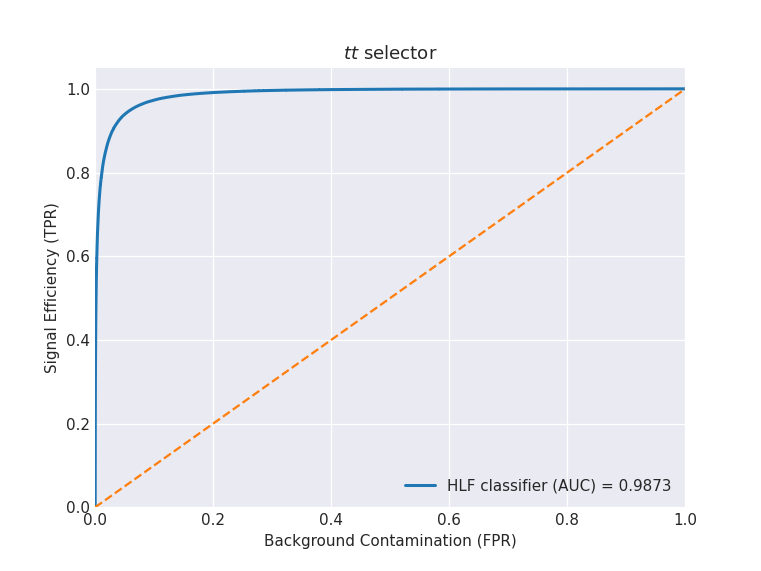

In [20]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()